In [4]:
# ======================================
# 0. 기본 라이브러리
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from bs4 import BeautifulSoup
import requests
import openpyxl
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
from selenium.webdriver.common.by  import By
from selenium.webdriver.common.keys import Keys

from pathlib import Path
import shutil
from datetime import datetime

import matplotlib.font_manager as fm
from matplotlib import rcParams


# ======================================
# 1. 스타일 먼저 (중요: 폰트보다 먼저)
# ======================================
plt.style.use('_mpl-gallery-nogrid')   # matplotlib 스타일
sns.set_theme(style="white")           # seaborn 기본 테마

# ======================================
# 2. 폰트 설정 (나눔고딕)
# ======================================
FONT_PATH = r"E:\seoul_pv_load_analysis\fonts\NanumGothic.ttf"

# matplotlib에 폰트 등록
fm.fontManager.addfont(FONT_PATH)

font_name = fm.FontProperties(fname=FONT_PATH).get_name()
rcParams["font.family"] = font_name
rcParams["font.sans-serif"] = [font_name]

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False

# (선택) 기본 폰트 사이즈 살짝 키우기
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# ======================================
# 3. 개별 객체용 폰트 (pie, title 등)
# ======================================
font_prop = fm.FontProperties(fname=FONT_PATH)

# ======================================
# 4. seaborn스타일 설정
# ======================================
sns.set_style("ticks") # 스타일 테마 설정
sns.set_context("notebook") # 문맥에 따라 스타일 크기 조정
sns.set_palette("pastel")

print(fm.FontProperties(fname=FONT_PATH).get_name())

NanumGothic


# DAY 9 — Seasonal Limitation of Solar PV on Evening Load

## 1. Analysis Question
태양광 발전은 계절에 따라 Evening Load를 얼마나 커버하지 못하는가?

## 2. Analysis Perspective
- Evening Load를 구조적 부담 구간으로 정의
- 본 분석은 전력 수요가 아닌 **태양광의 시간대·계절적 한계**에 초점

## 3. Data & Scope
- 대상 시간대: Evening Load (18–21시)
- 계절 구분: Summer / Winter
- 비교 관점:
  - Evening Load 자체의 변화
  - 태양광 가용 시간의 계절적 차이 (이론적 관점)

## 4. Method
- Evening Load 시간대 필터링
- 계절별 Evening 평균 부하 비교
- 태양광 이론적 발전 시간과의 구조적 관계 해석

## 5. Result
- Evening Load는 계절과 무관하게 반복적으로 나타남
- 반면 태양광 가용 시간은 계절에 따라 크게 달라짐

## 6. Interpretation
- 태양광은 Daytime 부하에는 기여 가능
- Evening Load는 태양광 발전 시간대와 구조적으로 불일치
- 이 불일치는 겨울철에 더욱 확대됨

## 7. Key Takeaway
태양광은 Evening Load에 대한 직접적 대응 수단이 아니며,
계절성은 이러한 한계를 더욱 분명하게 만든다.

In [7]:
# -------------------------
# 0) Load CSV (auto-find project root by /data)
# -------------------------
cwd = Path.cwd()
PROJECT_ROOT = None
for p in [cwd, *cwd.parents]:
    if (p / "data").exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("data 폴더를 찾지 못했습니다. notebooks 폴더에서 실행하거나 경로를 확인하세요.")

DATA_DIR = PROJECT_ROOT / "data"

# 여기 파일명만 네 파일로 맞춰도 됨
LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"
df_raw = pd.read_csv(LOAD_FILE)

print("Loaded:", LOAD_FILE.name)
print("Columns:", df_raw.columns.tolist())

# -------------------------
# 1) Build datetime (AUTO)
# -------------------------
if "datetime" in df_raw.columns:
    df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")

else:
    # 후보 컬럼 자동 탐지
    date_candidates = [c for c in df_raw.columns if c.upper() in ["USE_YM", "USE_DT", "USE_YMD", "DATE", "DT", "YMD"]]
    time_candidates = [c for c in df_raw.columns if c.upper() in ["USE_HM", "TIME", "HM", "HOUR", "HH"]]

    if not date_candidates or not time_candidates:
        raise KeyError(
            "datetime 생성용 날짜/시간 컬럼을 못 찾았어.\n"
            f"- date 후보: {date_candidates}\n"
            f"- time 후보: {time_candidates}\n"
            f"현재 컬럼: {df_raw.columns.tolist()}"
        )

    date_col = date_candidates[0]
    time_col = time_candidates[0]

    date_str = df_raw[date_col].astype(str).str.replace(r"\D", "", regex=True)
    time_str = df_raw[time_col].astype(str).str.replace(r"\D", "", regex=True)

    # time: HH -> HH00, H -> 0H00, HHMM -> 그대로
    time_str = time_str.str.zfill(2)
    time_str = time_str.where(time_str.str.len() != 1, "0" + time_str)
    time_str = time_str.where(time_str.str.len() != 2, time_str.str.zfill(4))
    time_str = time_str.where(time_str.str.len() != 2, time_str + "00")  # HH -> HH00
    time_str = time_str.str.zfill(4)

    # date: YYYYMMDD(8) 우선, 없으면 YYYYMM(6) 처리(월 데이터면 1일로 간주)
    def parse_datetime(d, t):
        if d.str.len().mode().iloc[0] == 8:
            return pd.to_datetime(d + t, format="%Y%m%d%H%M", errors="coerce")
        elif d.str.len().mode().iloc[0] == 6:
            # YYYYMM -> YYYYMM01 로 보정
            return pd.to_datetime(d + "01" + t, format="%Y%m%d%H%M", errors="coerce")
        else:
            # 마지막 방어: 그냥 합쳐서 추론
            return pd.to_datetime(d + t, errors="coerce")

    df_raw["datetime"] = parse_datetime(date_str, time_str)

# -------------------------
# 2) Clean + Base cols
# -------------------------
df = df_raw.dropna(subset=["datetime"]).copy()
df["hour"] = df["datetime"].dt.hour
df["month"] = df["datetime"].dt.month

# -------------------------
# 3) Standardize load column -> value
# -------------------------
if "value" not in df.columns:
    if "FDRCT_VLD_KWH" in df.columns:
        df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"], errors="coerce")
    else:
        raise KeyError("부하 컬럼을 못 찾았어. 'value' 또는 'FDRCT_VLD_KWH' 필요.")

df = df.dropna(subset=["value"]).copy()

print("Rows:", len(df))
print("Datetime range:", df["datetime"].min(), "~", df["datetime"].max())
print("Hour range:", df["hour"].min(), "~", df["hour"].max())
print("Month range:", df["month"].min(), "~", df["month"].max())

df[["datetime", "hour", "month", "value"]].head(3)


Loaded: 법정동별시간별전력사용량.csv
Columns: ['SIGUNGU_CD', 'BJDONG_CD', 'USE_YM', 'USE_HM', 'FDRCT_VLD_KWH']
Rows: 9350748
Datetime range: 2022-06-28 01:00:00 ~ 2024-01-28 23:00:00
Hour range: 1 ~ 23
Month range: 1 ~ 12


,datetime,hour,month,value
0,2022-06-28 01:00:00,1,6,10782.0565
1,2022-06-28 01:00:00,1,6,11394.8635
2,2022-06-28 01:00:00,1,6,7273.9620


In [8]:
# 1. 계절 라벨 만들기 (Summer, Winter)
def season_label(m):
    if m in [6, 7, 8]:
        return "Summer"
    elif m in [12, 1, 2]:
        return "Winter"
    else:
        return "Other"
    
df9 = df.copy()
df9["season"] = df9["month"].apply(season_label)
df9= df9[df9["season"].isin(["Summer", "Winter"])].copy()

In [9]:
# 24시간 평균 부하 곡선 만들기
hourly_profile = (df9.groupby(["season", "hour"])["value"].mean().reset_index())
pivot_profile = hourly_profile.pivot(index = "hour", columns = "season", values = "value").sort_index()
pivot_profile.head()

season,Summer,Winter
hour,,
1,6057.446933,4530.318400
2,5517.647646,4202.110788
3,5415.445720,4096.227232
4,4774.071546,4031.166402
5,5646.461962,4126.948619


In [15]:
# 태양광 이론 곡선 생성
hours = np.arange(24)

def pv_theoretical_curve(season):
    pv = np.zeros(24)

    if season == "Summer":
        sunrise, sunset = 6, 19 # 6시 ~ 19시 발전
    
    elif season == "Winter":
        sunrise, sunset = 8, 16 # 8시 ~ 16시 발전

    else:
        return pv
    
    for h in range(sunrise, sunset + 1):
        # 정오 (12시) 기준 종모양
        pv[h] = np.sin(np.pi * (h - sunrise) / (sunset - sunrise))
    
    # 정규화
    pv = np.clip(pv, 0, None)
    pv = pv / pv.max()

    return pv

pv_summer = pv_theoretical_curve("Summer")
pv_winter = pv_theoretical_curve("Winter")


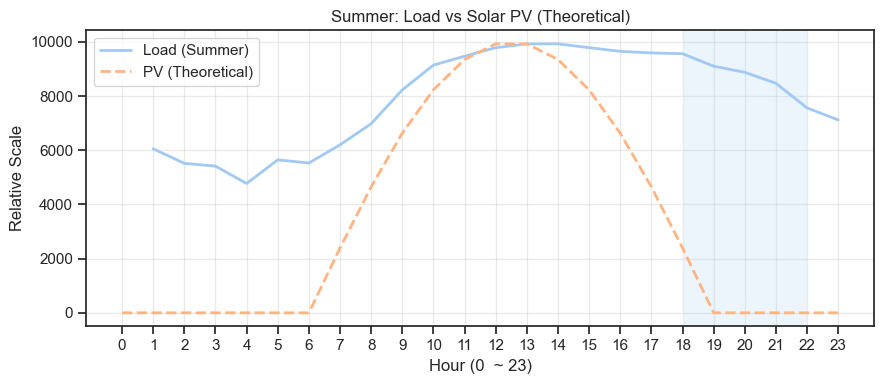

In [21]:
plt.figure(figsize = (9, 4))

# Summer
plt.plot(pivot_profile.index, pivot_profile["Summer"], label = "Load (Summer)", linewidth = 2)
plt.plot(hours, pv_summer * pivot_profile["Summer"].max(), linestyle = "--", label = "PV (Theoretical)", linewidth = 2)
plt.title("Summer: Load vs Solar PV (Theoretical)")
plt.xlabel("Hour (0  ~ 23)")
plt.ylabel("Relative Scale")
plt.xticks(range(0, 24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.legend()
plt.grid(alpha = .4)
plt.tight_layout()
plt.show()

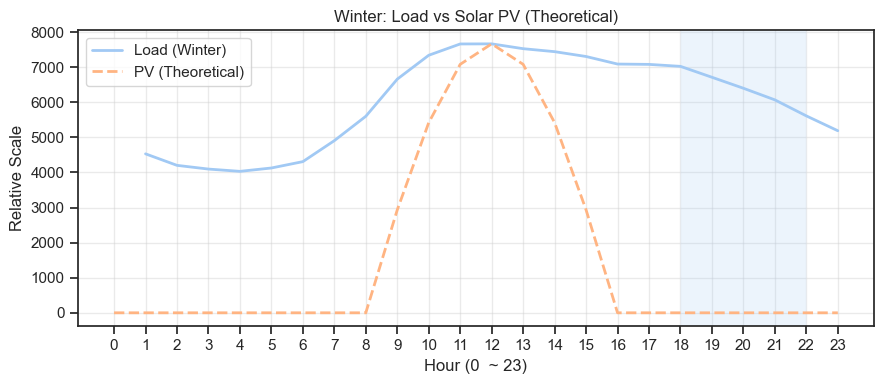

In [22]:
plt.figure(figsize = (9, 4))

# Winter
plt.plot(pivot_profile.index, pivot_profile["Winter"], label = "Load (Winter)", linewidth = 2)
plt.plot(hours, pv_winter * pivot_profile["Winter"].max(), linestyle = "--", label = "PV (Theoretical)", linewidth = 2)
plt.title("Winter: Load vs Solar PV (Theoretical)")
plt.xlabel("Hour (0  ~ 23)")
plt.ylabel("Relative Scale")
plt.xticks(range(0, 24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.legend()
plt.grid(alpha = .4)
plt.tight_layout()
plt.show()

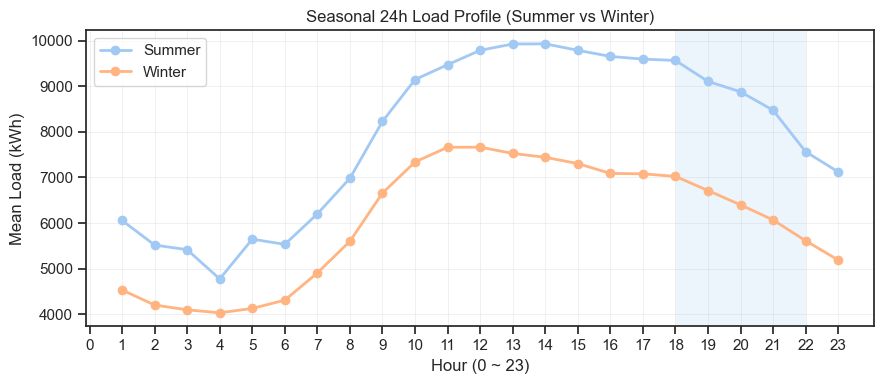

In [23]:
# 3) 그래프
plt.figure(figsize = (9, 4))
plt.plot(pivot_profile.index, pivot_profile["Summer"], marker = "o", linewidth = 2, label = "Summer")
plt.plot(pivot_profile.index, pivot_profile["Winter"], marker = "o", linewidth = 2, label = "Winter")

plt.xticks(range(0, 24, 1))
plt.axvspan(18, 22, alpha=0.2)
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Mean Load (kWh)")
plt.title("Seasonal 24h Load Profile (Summer vs Winter)")
plt.grid(True, linewidth = .5, alpha = .4)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# 1) Evening Load 필터 (18–21시)
evening_hours = [18, 19, 20, 21]
evening_df = df9[df9["hour"].isin(evening_hours)].copy()

In [29]:
# 2) 계절별 이브닝 시간대 프로파일 (형태 비교)
evening_profile = (
    evening_df
    .groupby(["season", "hour"])["value"]
    .mean()
    .reset_index())

pivot_evening = (
    evening_profile
    .pivot(index="hour", columns="season", values="value")
    .reindex(evening_hours))

pivot_evening


season,Summer,Winter
hour,,
18,9566.612323,7023.511775
19,9107.307643,6712.469824
20,8878.561632,6399.433974
21,8474.345639,6068.284600


In [30]:
# 3) 계절별 이브닝 평균값 (요약 지표)
evening_mean = (evening_df .groupby("season")["value"].mean().reindex(["Summer", "Winter"]))

evening_mean


season
Summer    9006.706809
Winter    6553.463696
Name: value, dtype: float64

In [31]:
daily_mean = (df9.groupby(["season", "hour"])["value"] .mean() .groupby("season").mean())

evening_ratio = (evening_mean / daily_mean).rename("Evening_to_Daily_Ratio")
evening_ratio

season
Summer    1.135849
Winter    1.087730
Name: Evening_to_Daily_Ratio, dtype: float64

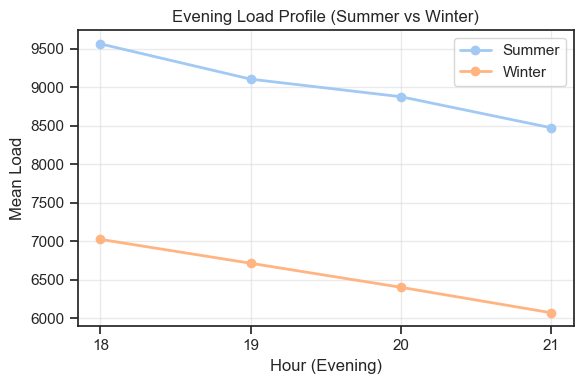

In [32]:
# 이브닝 전용 그래프
plt.figure(figsize=(6,4))
plt.plot(pivot_evening.index, pivot_evening["Summer"], marker="o", linewidth=2, label="Summer")
plt.plot(pivot_evening.index, pivot_evening["Winter"], marker="o", linewidth=2, label="Winter")

plt.xticks(evening_hours)
plt.xlabel("Hour (Evening)")
plt.ylabel("Mean Load")
plt.title("Evening Load Profile (Summer vs Winter)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


Evening Load는 계절과 관계없이 반복적으로 나타난다.
반면 태양광 발전은 이 시간대에 가용하지 않으며, 계절 변화는 이러한 시간대 불일치를 해소하지 못한다.

In [ ]:
# =========================
# DAY 9 Conclusion (Seasonal)
# =========================

evening_mean = (df9[df9["hour"].between(18, 21)].groupby("season")["value"].mean().reindex(["Summer", "Winter"]))

daily_mean = (df9.groupby("season")["value"].mean().reindex(["Summer", "Winter"]))

evening_share = (evening_mean / daily_mean)

summary = pd.DataFrame({
    "Evening mean (18-21)": evening_mean,
    "Daily mean (0-23)": daily_mean,
    "Evening share (Evening/Daily)": evening_share})

display(summary)

delta = evening_mean["Winter"] - evening_mean["Summer"]
ratio = evening_mean["Winter"] / evening_mean["Summer"]

print("[DAY 9 핵심 요약]")
print(f"- 이브닝 시간대(18–21시) 평균 부하는 계절에 따라 차이를 보이며, 계절 효과가 관측된다.")
print(f"- 겨울/여름 이브닝 부하 비율: {ratio:.2f}배")
print()
print("최종 메시지:")
print("계절적 요인은 태양광의 상대적 기여 가능성에 영향을 주지만, 이브닝 시간대의 구조적 전력 부담 자체를 해소하지는 못한다.")


,Evening mean (18-21),Daily mean (0-23),Evening share (Evening/Daily)
season,,,
Summer,9006.706809,7928.640783,1.135971
Winter,6553.463696,6025.447470,1.087631


[DAY 9 핵심 요약]
- 이브닝 시간대(18–21시) 평균 부하는 계절에 따라 차이를 보이며, 계절 효과가 관측된다.
- 겨울/여름 이브닝 부하 비율: 0.73배

최종 메시지:
계절적 요인은 태양광의 상대적 기여 가능성에 영향을 주지만, 이브닝 시간대의 구조적 전력 부담 자체를 해소하지는 못한다.
